In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import timeit

In [2]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the mean per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Means_Clean.csv')
# data1 will have all the protein level data in columns with the independent variables moved to the index
data1 = data.set_index(['Genotype','Behavior','Treatment'])
data1.drop(['class','Mouse'],axis = 1, inplace = True)
data.head()

,Genotype,Behavior,Treatment,class,Mouse,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,...,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,Control,C/S,Memantine,c-CS-m,309,0.421063,0.576510,0.356447,2.278252,4.354744,...,0.832559,0.192871,0.151524,NaN,0.115433,0.423088,0.136374,0.169300,0.169590,1.674160
1,Control,C/S,Memantine,c-CS-m,311,0.600591,0.678479,0.334548,2.277561,4.234706,...,0.673229,0.188092,0.166315,0.168952,NaN,0.426774,0.141512,0.201386,0.200284,1.193285
2,Control,C/S,Memantine,c-CS-m,320,0.547676,0.796012,0.398649,2.664515,5.498960,...,0.859745,0.218300,0.159284,0.138537,0.123580,0.538909,0.141971,0.187006,NaN,1.624791
3,Control,C/S,Memantine,c-CS-m,321,0.438728,0.652045,0.359441,2.686405,5.298355,...,0.922949,0.238123,NaN,0.158817,NaN,0.559531,0.150542,0.220306,NaN,1.678225
4,Control,C/S,Memantine,c-CS-m,322,0.358931,0.512223,0.315105,2.111664,4.231444,...,0.828905,0.239495,NaN,0.154224,0.141323,0.493076,NaN,NaN,NaN,1.607234


In [3]:
def get_bootstrap_replicates(data, func=np.mean, size=10000):
    n = len(data)
    bootstrap_replicates = np.asarray([func(np.random.choice(data, n)) for i in range(size)])
    return bootstrap_replicates

def bootstrap_test_means(data1, data2, n_reps = 10000):
    group_mean = np.mean(np.concatenate((data1, data2)))
    data1_shifted = data1 - np.mean(data1) + group_mean
    data2_shifted = data2 - np.mean(data2) + group_mean
    mean_reps_1 = get_bootstrap_replicates(data1_shifted, func = np.mean, size = n_reps)
    mean_reps_2 = get_bootstrap_replicates(data2_shifted, func = np.mean, size = n_reps)
    bs_reps = mean_reps_1 - mean_reps_2
    obs_diff = np.mean(data1) - np.mean(data2)
    p_value = np.sum(np.abs(bs_reps) > np.abs(obs_diff))/n_reps
    return p_value

In [4]:
def split_data(field, tag):
    group1_data = data.query(field + ' == @tag')
    group2_data = data.query(field + ' != @tag')
    return(group1_data, group2_data)

# Maximum number of comparisons = 3 variables * 76 proteins = 228
# Minimum Q value = FDR * 1/228
# Maximum n_reps s.t. expected # of more extreme values @ null = 10:
# 228/FDR*10.  45600 with FDR = 0.05, 228,000 with FDR = 0.01

variables =    ('Genotype', 'Behavior', 'Treatment')
control_tags = ('Control',  'S/C',      'Saline')
proteins = data.columns[5:]
fdr = 0.05

candidate_proteins = ['DYRK1A_N', 'ITSN1_N', 'CaNA_N',      'SOD1_N',   'pERK_N', 
                      'BRAF_N',   'GSK3B_N', 'pPKCAB_N',    'P38_N',    'pMTOR_N', 
                      'PSD95_N',  'SNCA_N',  'Ubiquitin_N', 'H3MeK4_N', 'EGR1_N']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


Mean time per 100000 replicate test: 11.17s
Total time for 15 tests: 167.52s


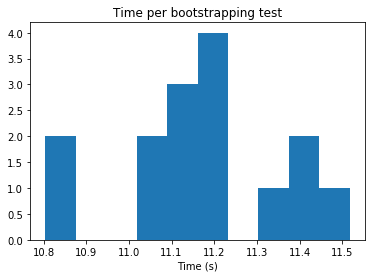

In [9]:
time0 = timeit.default_timer()
n_vars = 1
n_proteins = 15
n_comparisons = n_vars * n_proteins
times = np.empty(n_comparisons)
n_reps = 100000
test_values = {'protein':     [''] * n_comparisons,
               'variable':    [''] * n_comparisons,
               'p_value':     np.empty(n_comparisons),
               'p_rank':      np.empty(n_comparisons),
               'q_value':     np.empty(n_comparisons),
               'significant': np.asarray(['False'] * n_comparisons)}
idx = 0
variable = variables[0]
tag = control_tags[1]
#for variable, tag in zip(variables, tags):
control, experim = split_data(variable, tag)

for protein in candidate_proteins:
    test_values['protein'][idx]  = protein
    test_values['variable'][idx] = variable
    group1 = control[protein].dropna()
    group2 = experim[protein].dropna()
    start_time = timeit.default_timer()
    test_values['p_value'][idx] = bootstrap_test_means(group1, group2, n_reps)
    times[idx] = timeit.default_timer() - start_time
    idx +=1

total_time = timeit.default_timer() - time0
    
_ = plt.hist(times)
_ = plt.xlabel('Time (s)')
_ = plt.title('Time per bootstrapping test')
print('Mean time per %d replicate test: %.2fs' %(n_reps, np.mean(times)))
print('Total time for %d tests: %.2fs' %(n_comparisons, total_time))

In [6]:
# Multiple comparisons correction by Benjamini–Hochberg procedure
test_values['p_rank'] = stats.rankdata(test_values['p_value'])
test_values['q_value'] = test_values['p_rank']/n_comparisons*fdr
cutoff = test_values['p_value'][test_values['p_value'] < test_values['q_value']]
if len(cutoff)>0:
    highest = max(cutoff)
    test_values['significant'][test_values['p_value'] <= highest] = True
pd.DataFrame(test_values)

,protein,variable,p_value,p_rank,q_value,significant
0,DYRK1A_N,Genotype,0.0,8.0,0.026667,True
1,ITSN1_N,Genotype,0.0,8.0,0.026667,True
2,CaNA_N,Genotype,0.0,8.0,0.026667,True
3,SOD1_N,Genotype,0.0,8.0,0.026667,True
4,pERK_N,Genotype,0.0,8.0,0.026667,True
5,BRAF_N,Genotype,0.0,8.0,0.026667,True
6,GSK3B_N,Genotype,0.0,8.0,0.026667,True
7,pPKCAB_N,Genotype,0.0,8.0,0.026667,True
8,P38_N,Genotype,0.0,8.0,0.026667,True
9,pMTOR_N,Genotype,0.0,8.0,0.026667,True
